In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from defusedxml.lxml import tostring
from networkx.algorithms.bipartite.basic import color
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [70]:
path = "HousePricingHCM_v2.csv"  # Dataset from https://www.kaggle.com/datasets/trnduythanhkhttt/housepricinghcm
house_pricing_dataset = pd.read_csv(path, parse_dates=["Date"])
house_pricing_dataset = house_pricing_dataset.set_index('Date').to_period('D')

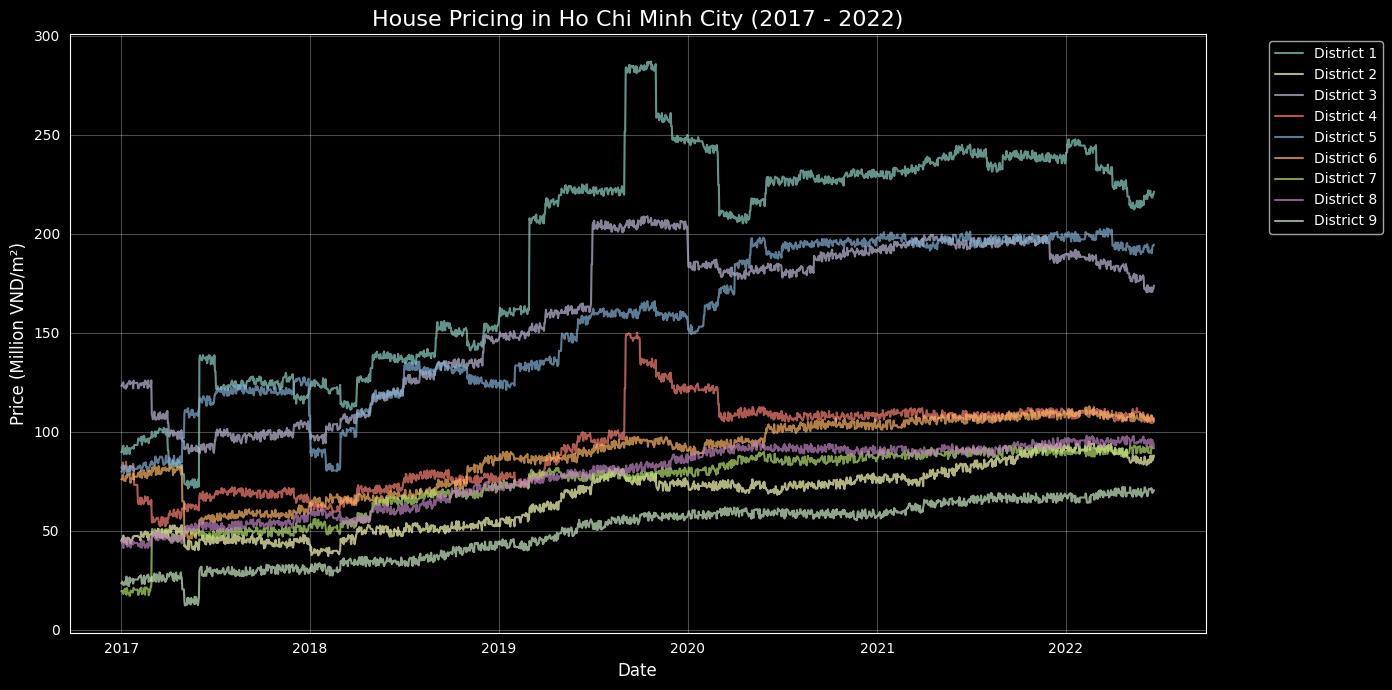

In [71]:
plt.figure(figsize=(14, 7))
for column in house_pricing_dataset.columns:
    plt.plot(house_pricing_dataset.index.to_timestamp(), house_pricing_dataset[column],
             alpha=0.7, label=column)
plt.title("House Pricing in Ho Chi Minh City (2017 - 2022)", fontsize=16)
plt.ylabel("Price (Million VND/m²)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
district = "District 2"
district1 = house_pricing_dataset[district]

y = district1.copy().to_timestamp(how='start')

In [73]:
trend_district1 = district1.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

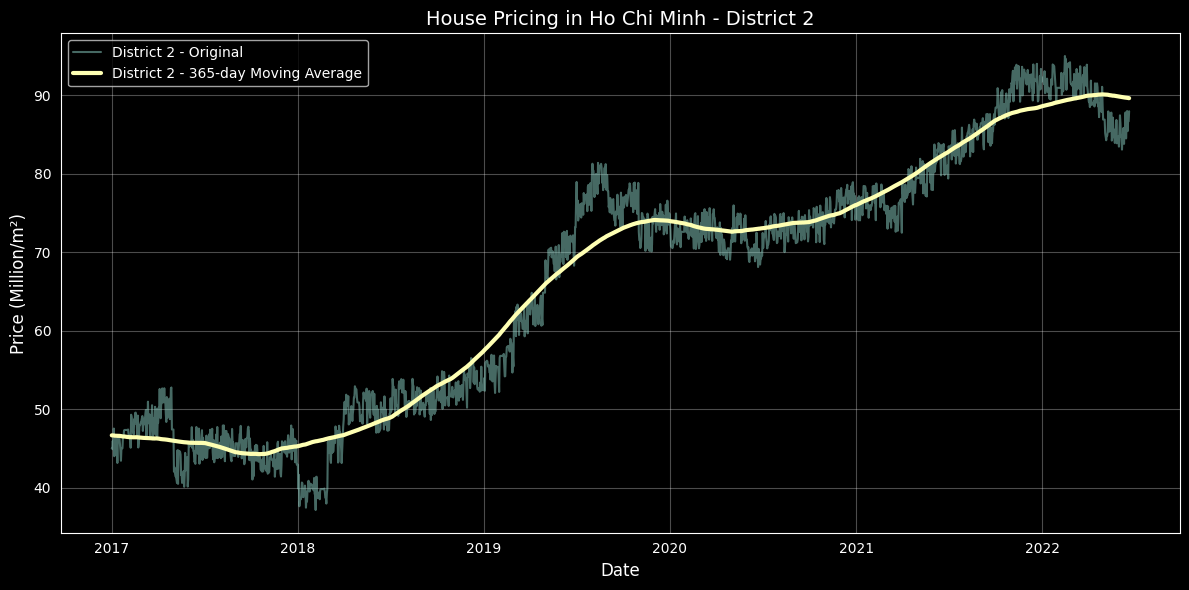

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(district1.index.to_timestamp(), district1, alpha=0.5, label=district +' - Original')
plt.plot(trend_district1.index.to_timestamp(), trend_district1, linewidth=3, label= district + ' - 365-day Moving Average')
plt.title("House Pricing in Ho Chi Minh - " + district, fontsize=14)
plt.ylabel("Price (Million/m²)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [75]:
trend_all = house_pricing_dataset.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

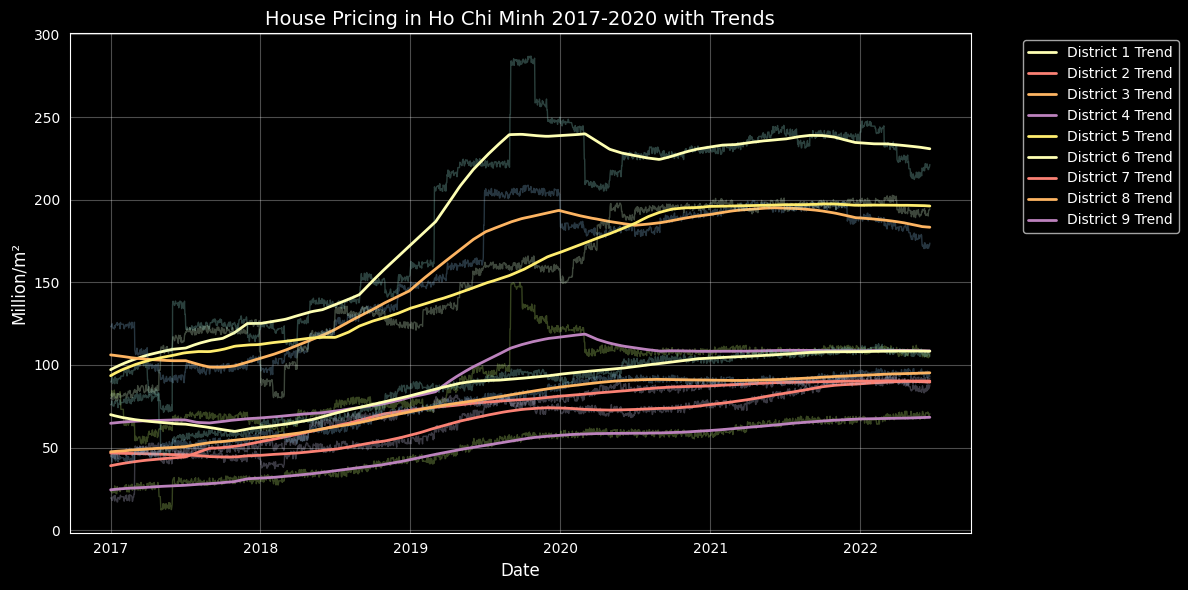

In [76]:
#All districts with their trends
plt.figure(figsize=(12, 6))
for column in house_pricing_dataset.columns:
    plt.plot(house_pricing_dataset.index.to_timestamp(), house_pricing_dataset[column],
             alpha=0.3, linewidth=1)
    plt.plot(trend_all.index.to_timestamp(), trend_all[column],
             linewidth=2, label=f'{column} Trend')
plt.title("House Pricing in Ho Chi Minh 2017-2020 with Trends", fontsize=14)
plt.ylabel("Million/m²", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Model Fitting (Holt-Winters)
model = ExponentialSmoothing(
    y,
    trend="add",
    seasonal="add",
    seasonal_periods=365
)
fit = model.fit(optimized=True)

/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [78]:
y_pred = fit.fittedvalues
y_fore = fit.forecast(120)

/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [79]:
#index
start_forecast = y.index[-1] + pd.Timedelta(days=1)
future_dates = pd.date_range(start=start_forecast, periods=120, freq='D')
y_fore.index = future_dates

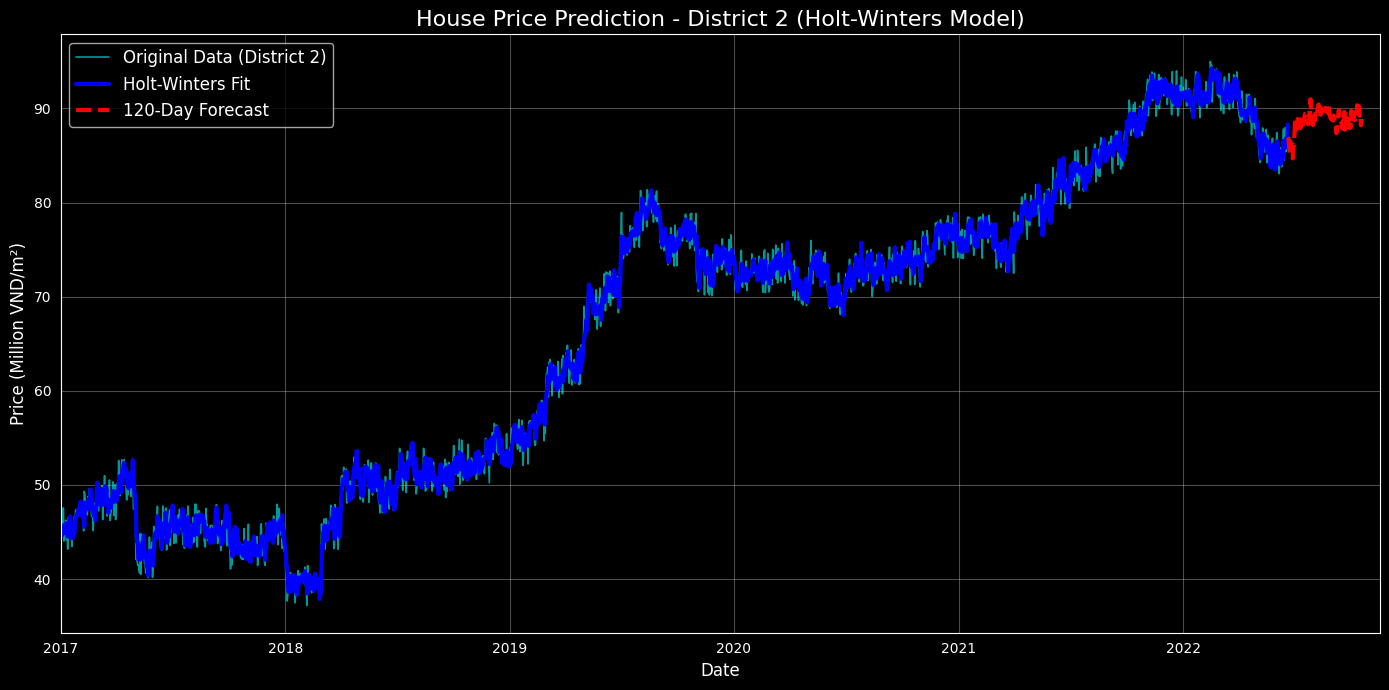

In [80]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, alpha=0.6, label=f'Original Data ({district})', color='cyan', linewidth=1.2)
plt.plot(y_pred.index, y_pred, linewidth=3, label='Holt-Winters Fit', color='blue')
plt.plot(y_fore.index, y_fore, linewidth=3, label='120-Day Forecast', color='red', linestyle='--')
plt.title(f"House Price Prediction - {district} (Holt-Winters Model)", fontsize=16)
plt.ylabel("Price (Million VND/m²)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(pd.Timestamp('2017-01-01'), y_fore.index[-1] + pd.Timedelta(days=30))
plt.tight_layout()
plt.show()

In [81]:
#First 10 days
print("10 days after 21/06/2022:")
forecast_df = pd.DataFrame({'Date': y_fore.index, 'Predicted Price (Million/m²)': y_fore.values})
print(forecast_df.head(10).round(2))

10 days after 21/06/2022:
        Date  Predicted Price (Million/m²)
0 2022-06-21                         86.95
1 2022-06-22                         85.99
2 2022-06-23                         85.27
3 2022-06-24                         86.48
4 2022-06-25                         86.14
5 2022-06-26                         85.34
6 2022-06-27                         85.31
7 2022-06-28                         84.69
8 2022-06-29                         86.14
9 2022-06-30                         86.10


In [82]:
# Prophet
df_prophet = pd.DataFrame({
    'ds': district1.index.to_timestamp(),
    'y': district1.values
})

In [83]:
# Model Fitting
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
m.add_seasonality(name='yearly', period=365.25, fourier_order=10)
m.fit(df_prophet)

00:27:17 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# 120
future = m.make_future_dataframe(periods=120, freq='D')
forecast = m.predict(future)

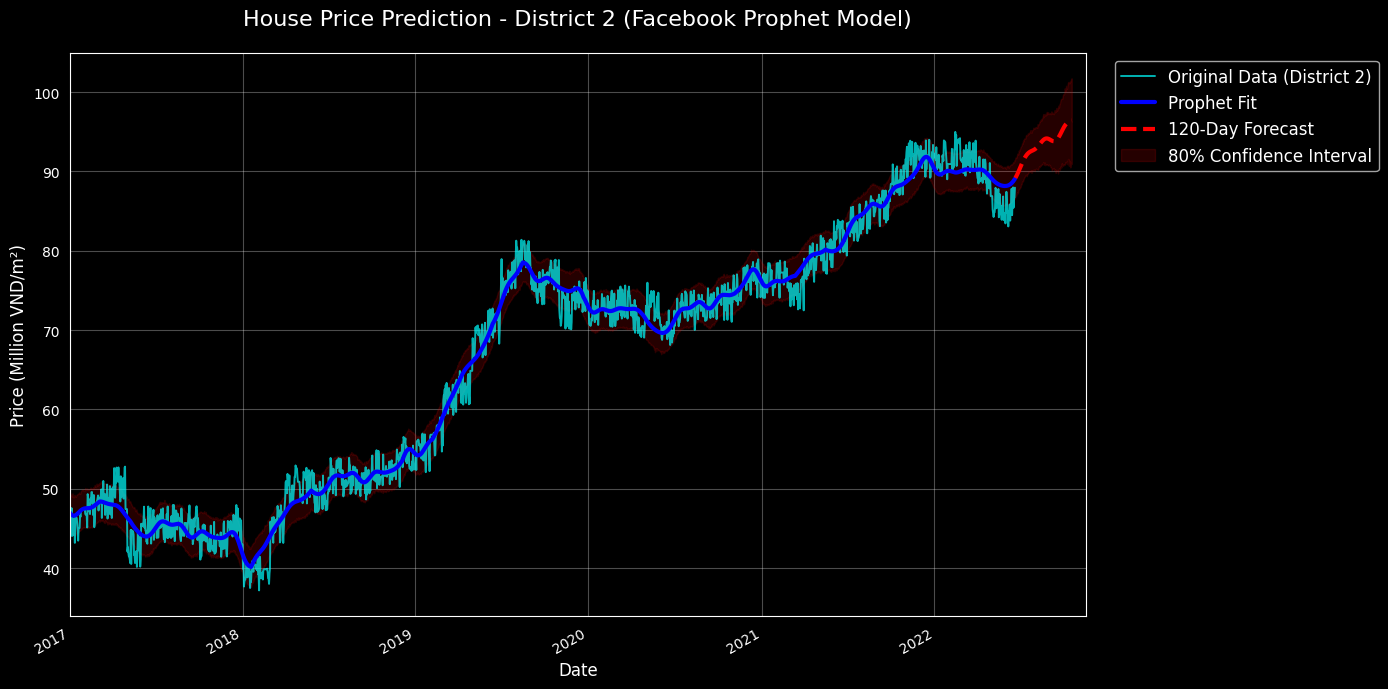

In [85]:
#plot
plt.figure(figsize=(14, 7))

plt.plot(df_prophet['ds'], df_prophet['y'],
         color='cyan', alpha=0.7, linewidth=1.4, label=f'Original Data ({district})')
plt.plot(forecast['ds'][:len(df_prophet)], forecast['yhat'][:len(df_prophet)],
         color='blue', linewidth=3, label='Prophet Fit')
#predict
plt.plot(forecast['ds'][len(df_prophet):], forecast['yhat'][len(df_prophet):],
         color='red', linewidth=3, linestyle='--', label='120-Day Forecast')

plt.fill_between(forecast['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='red', alpha=0.15, label='80% Confidence Interval')

plt.title(f"House Price Prediction - {district} (Facebook Prophet Model)", fontsize=16, pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (Million VND/m²)", fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

#show grid
plt.xlim(pd.Timestamp('2017-01-01'), forecast['ds'].max() + pd.Timedelta(days=30))
plt.grid(True, alpha=0.3)

plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

In [86]:
#10 days
last_date = df_prophet['ds'].max()
print(f"10 days after {(last_date + pd.Timedelta(days=1)).strftime('%d/%m/%Y')}:")
pred_future = forecast[forecast['ds'] > last_date][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(10)
pred_future['ds'] = pred_future['ds'].dt.strftime('%d/%m/%Y')
pred_future = pred_future.rename(columns={
    'ds': 'Date',
    'yhat': 'Predicted Price (Million/m²)',
    'yhat_lower': 'y_lower',
    'yhat_upper': 'y_upper'
})
print(pred_future.round(2))

10 days after 21/06/2022:
            Date  Predicted Price (Million/m²)  y_lower  y_upper
1996  21/06/2022                         89.18    86.86    91.73
1997  22/06/2022                         89.29    86.88    91.78
1998  23/06/2022                         89.41    86.96    91.69
1999  24/06/2022                         89.52    87.30    91.96
2000  25/06/2022                         89.65    87.40    92.20
2001  26/06/2022                         89.78    87.22    92.29
2002  27/06/2022                         89.91    87.44    92.12
2003  28/06/2022                         90.05    87.77    92.62
2004  29/06/2022                         90.18    87.77    92.51
2005  30/06/2022                         90.32    87.87    92.76


In [87]:
def gm11_forecast(series, forecast_steps=120):
    x0 = np.array(series.values).astype(float)
    n = len(x0)

    if n < 4:
        raise ValueError("Data too short for GM(1,1)")
    # 1. Accumulated Generating Operation (AGO)
    x1 = np.cumsum(x0)

    # 2. Mean sequence Z
    z = (x1[:-1] + x1[1:]) / 2.0

    # 3. Matrix B and vector Y
    B = np.vstack([-z, np.ones(n-1)]).T
    Y = x0[1:]

    # 4. Least squares để tìm a (development coefficient) và b (grey input)
    params = np.linalg.lstsq(B, Y, rcond=None)[0]
    a, b = params

    #    \hat{x1}(k+1) = (x0(1) - b/a) * exp(-a*k) + b/a
    #    \hat{x0}(k+1) = \hat{x1}(k+1) - \hat{x1}(k)
    def predicted_ago(k):  # k bắt đầu từ 1
        return (x0[0] - b/a) * np.exp(-a * (k-1)) + b/a

    # Fitted values (k=1 to n)
    fitted_ago = np.array([predicted_ago(k) for k in range(1, n+1)])
    fitted = np.diff(fitted_ago, prepend=x0[0])  # IAGO để về x0

    # Forecast
    forecast_ago = np.array([predicted_ago(k) for k in range(n+1, n+forecast_steps+1)])
    forecast = np.diff(forecast_ago, prepend=fitted_ago[-1])

    return fitted, forecast, a, b

In [88]:
fitted_gm, forecast_gm, a_gm, b_gm = gm11_forecast(y)

In [89]:
#120
last_date = y.index[-1]
future_dates_gm = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=120, freq='D')

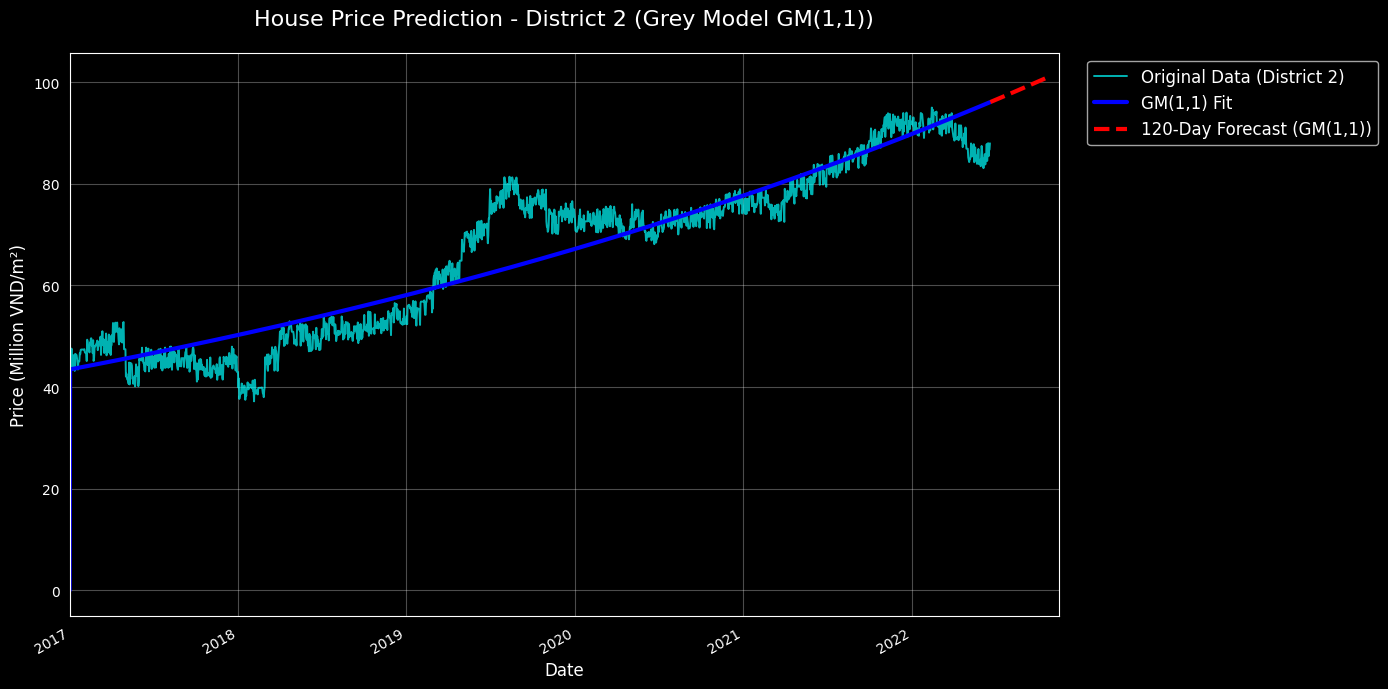

In [90]:
#plot
plt.figure(figsize=(14, 7))

plt.plot(y.index, y.values, color='cyan', alpha=0.7, linewidth=1.4, label=f'Original Data ({district})')
plt.plot(y.index, fitted_gm, color='blue', linewidth=3, label='GM(1,1) Fit')  # xanh lá
#predict
plt.plot(future_dates_gm, forecast_gm, color='red', linewidth=3, linestyle='--', label='120-Day Forecast (GM(1,1))')

plt.title(f"House Price Prediction - {district} (Grey Model GM(1,1))", fontsize=16, pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (Million VND/m²)", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()
plt.grid(True, alpha=0.3)
plt.xlim(pd.Timestamp('2017-01-01'), future_dates_gm[-1] + pd.Timedelta(days=30))
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

In [91]:
#10 days
print(f"\n10 days after {(last_date + pd.Timedelta(days=1)).strftime('%d/%m/%Y')}:")
forecast_df_gm = pd.DataFrame({
    'Date': future_dates_gm[:10].strftime('%d/%m/%Y'),
    'Predicted Price (Million/m²)': np.round(forecast_gm[:10], 2)
})
print(forecast_df_gm.to_string(index=False))


10 days after 21/06/2022:
      Date  Predicted Price (Million/m²)
21/06/2022                         96.07
22/06/2022                         96.11
23/06/2022                         96.15
24/06/2022                         96.19
25/06/2022                         96.23
26/06/2022                         96.26
27/06/2022                         96.30
28/06/2022                         96.34
29/06/2022                         96.38
30/06/2022                         96.42


In [92]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [93]:
# Holt-Winters
y_actual = y.values
y_fitted_hw = fit.fittedvalues.values

# Prophet
y_fitted_prophet = forecast[forecast['ds'] <= df_prophet['ds'].max()]['yhat'].values

In [94]:
mae_hw = mean_absolute_error(y_actual, y_fitted_hw)
rmse_hw = np.sqrt(mean_squared_error(y_actual, y_fitted_hw))
mape_hw = mean_absolute_percentage_error(y_actual, y_fitted_hw)

mae_prophet = mean_absolute_error(y_actual, y_fitted_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_actual, y_fitted_prophet))
mape_prophet = mean_absolute_percentage_error(y_actual, y_fitted_prophet)

mae_gm = mean_absolute_error(y.values, fitted_gm)
rmse_gm = np.sqrt(mean_squared_error(y.values, fitted_gm))
mape_gm = mean_absolute_percentage_error(y.values, fitted_gm)

print(f"Holt-Winters Exponential Smoothing:")
print(f"   MAE  : {mae_hw:.2f} Million/m²")
print(f"   RMSE : {rmse_hw:.2f} Million/m²")
print(f"   MAPE : {mape_hw:.2f}%\n")

print(f"Facebook Prophet:")
print(f"   MAE  : {mae_prophet:.2f} Million/m²")
print(f"   RMSE : {rmse_prophet:.2f} Million/m²")
print(f"   MAPE : {mape_prophet:.2f}%\n")

print(f"Grey Model GM(1,1):")
print(f"   MAE  : {mae_gm:.2f} Million/m²")
print(f"   RMSE : {rmse_gm:.2f} Million/m²")
print(f"   MAPE : {mape_gm:.2f}%\n")

Holt-Winters Exponential Smoothing:
   MAE  : 1.01 Million/m²
   RMSE : 1.28 Million/m²
   MAPE : 1.64%

Facebook Prophet:
   MAE  : 1.49 Million/m²
   RMSE : 1.88 Million/m²
   MAPE : 2.41%

Grey Model GM(1,1):
   MAE  : 4.20 Million/m²
   RMSE : 5.61 Million/m²
   MAPE : 6.92%



In [95]:
train_ratio = 0.8
train_size = int(len(y) * train_ratio)

y_train_series = y.iloc[:train_size]
y_test_series = y.iloc[train_size:]
y_train = y_train_series.values
y_test = y_test_series.values

# Holt-Winters on training
model_hw_train = ExponentialSmoothing(
    y_train_series,  # dùng Series có datetime index
    trend="add",
    seasonal="add",
    seasonal_periods=365
)
fit_hw_train = model_hw_train.fit(optimized=True)
fitted_train_hw = fit_hw_train.fittedvalues.values
forecast_test_hw = fit_hw_train.forecast(len(y_test)).values

mae_train_hw = mean_absolute_error(y_train, fitted_train_hw)
mae_test_hw = mean_absolute_error(y_test, forecast_test_hw)

# Prophet on training
df_train = df_prophet.iloc[:train_size].copy()
m_train = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
m_train.add_seasonality(name='yearly', period=365.25, fourier_order=10)
m_train.fit(df_train)

forecast_train_prophet = m_train.predict(df_train)
fitted_train_prophet = forecast_train_prophet['yhat'].values

future_test_prophet = m_train.make_future_dataframe(periods=len(y_test), freq='D')
forecast_full_prophet = m_train.predict(future_test_prophet)
forecast_test_prophet = forecast_full_prophet['yhat'].values[train_size:]

mae_train_prophet = mean_absolute_error(y_train, fitted_train_prophet)
mae_test_prophet = mean_absolute_error(y_test, forecast_test_prophet)

# GM(1,1) on training
fitted_train_gm, forecast_test_gm, _, _ = gm11_forecast(y_train_series, len(y_test))

mae_train_gm = mean_absolute_error(y_train, fitted_train_gm)
mae_test_gm = mean_absolute_error(y_test, forecast_test_gm)


print("Holt-Winters:")
print(f"   MAE Train : {mae_train_hw:.2f}")
print(f"   MAE Test  : {mae_test_hw:.2f}")
print(f"   Diff      : {mae_test_hw - mae_train_hw:.2f}\n")

print("Facebook Prophet:")
print(f"   MAE Train : {mae_train_prophet:.2f}")
print(f"   MAE Test  : {mae_test_prophet:.2f}")
print(f"   Diff      : {mae_test_prophet - mae_train_prophet:.2f}\n")

print("Grey Model GM(1,1):")
print(f"   MAE Train : {mae_train_gm:.2f}")
print(f"   MAE Test  : {mae_test_gm:.2f}")
print(f"   Diff      : {mae_test_gm - mae_train_gm:.2f}")

/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/trysnguyen/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a mode

Holt-Winters:
   MAE Train : 1.00
   MAE Test  : 7.23
   Diff      : 6.22

Facebook Prophet:
   MAE Train : 1.43
   MAE Test  : 5.38
   Diff      : 3.95

Grey Model GM(1,1):
   MAE Train : 4.58
   MAE Test  : 4.27
   Diff      : -0.31
